# Import necessary packages, aka, "Why write all over again, code that someone else has written ?"

In [1]:
from __future__ import print_function, division

# All the torch stuff goes here...

import torch
import torch.nn as nn # Look at that, no need to say anything specific like Conv2D or Maxpool2D here !!! tensorflow: declare anything before
import torch.optim as optim
from torch.optim import lr_scheduler

# All the torch vision stuff goes next...

import torchvision
from torchvision import datasets, models, transforms

#All the non-torchy stuff goes last...

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode !

# Understanding the problem, load the data (how else can we get started ?) and some preprocessing

In [2]:
%pwd

'/Users/ram/Desktop/INFO 7390'

In [4]:
'''Image classification using a small dataset. This one happens to be a binary classification problem.
Specifically we want to tell apart ants from bees.


The training set size is 120 and the validation set size is 75.

We do data augmentation for the training set. Why ? Well because people take pictures in different ways !
Fortunately, given one picture, we can recreate some of the other ways the same picture could have been taken.
Say, from another angle !

For both training and validation data, we also crop and normalize. Why ?
Looks like no one likes large numbers, especially when thigns are different across pictures !
Define these functions beforehand'''

data_dir = '/Users/ram/Desktop/INFO 7390/hymenoptera_data' #Don't forget the data !

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#Note those funny decimal numbers you see there are actually the means and standard deviations 
#for the three channels. Those were pre-computed for this example. You can use a package like 
#Python openCV to compute these


In [6]:
'''Time to read-in the data'''

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

In [7]:
'''Get some basic information about the datasets which we will need later !'''

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']} 

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Nope all my laptop has is a humble CPU

In [11]:
'''Print those out !'''
print(dataset_sizes,class_names)

{'train': 244, 'val': 153} ['ants', 'bees']


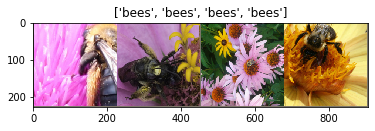

In [12]:
'''Never trust numbers by themselves, especially, when you can see the pictures !'''

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Model building

In [12]:
'''Define functions for training the model and visualizing the results. After every
epoch of training, the model is evaluated on the validation set.'''

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) #How else can you capture the weights of best model ! 1. layer 2. number of matrix
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad() # trash the parameter gradients after every minibatch !!! Till here

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train': # backward + optimize only if in training phase
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)  # calculate statistics
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [13]:
'''Time to Finetune resnet'''

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /Users/ram/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [14]:
'''Train and evaluate the model'''

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4727 Acc: 0.7377
val Loss: 0.2642 Acc: 0.9281

Epoch 1/24
----------
train Loss: 0.4595 Acc: 0.8033
val Loss: 0.2307 Acc: 0.9281

Epoch 2/24
----------
train Loss: 0.4411 Acc: 0.7951
val Loss: 0.2568 Acc: 0.9020

Epoch 3/24
----------
train Loss: 0.5576 Acc: 0.7500
val Loss: 0.2808 Acc: 0.8693

Epoch 4/24
----------
train Loss: 0.5881 Acc: 0.7500
val Loss: 0.1703 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.4221 Acc: 0.8197
val Loss: 0.1821 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.5738 Acc: 0.7787
val Loss: 1.0357 Acc: 0.6863

Epoch 7/24
----------
train Loss: 0.4665 Acc: 0.8279
val Loss: 0.2130 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.3267 Acc: 0.8730
val Loss: 0.2366 Acc: 0.9085

Epoch 9/24
----------
train Loss: 0.2010 Acc: 0.9098
val Loss: 0.1940 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.2985 Acc: 0.8770
val Loss: 0.1831 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.2653 Acc: 0.8893
val Loss: 0.1792 Acc: 0.9412

Ep